In [1]:
import cv2
import dlib
import yaml
import numpy as np
import os

In [2]:
# load face detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("weights/shape_predictor_68_face_landmarks.dat")

# load images
img_dir = "examples/test/original"
list_dir = os.listdir(img_dir)

# new dict for keypoints
landmarks = {}

# select images
idx = 0
img_name = list_dir[idx]


# dlib_kps

In [3]:
_, extension = os.path.splitext(img_name)

# only do it for images, not .json file
assert extension != '.json'

# load image
img_path = os.path.join(img_dir, img_name)
image = cv2.imread(img_path)

# gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect face
rects = detector(gray, 1)


Number of faces detected: 1
Detected face 1
id 0 - Face co-ordinates: (1620, 1068) (3276, 2724)


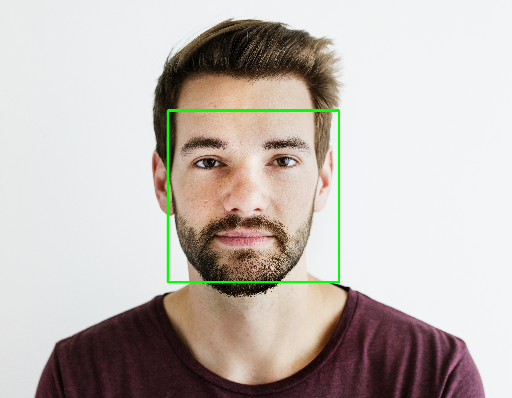

In [4]:
print("Number of faces detected: {}".format(len(rects)))
for (i, rect) in enumerate(rects):
    print("Detected face {}".format(i + 1))
    x1, y1 = rect.tl_corner().x, rect.tl_corner().y
    x2, y2 = rect.br_corner().x, rect.br_corner().y
    print("id {} - Face co-ordinates: ({}, {}) ({}, {})".format(i, x1, y1, x2, y2))
    w, h = image.shape[:2]
    scale = 512/h
    vis_image = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 255, 0), int(2/scale))
    vis_image = cv2.resize(vis_image, (0, 0), fx=scale, fy=scale)
    from PIL import Image
    display(Image.fromarray(vis_image[..., ::-1]))

In [5]:
# detect landmarks
for (i, rect) in enumerate(rects):
    # get keypoints
    shape = predictor(gray, rect)

    # save kps to the dict
    # ! will data be overwritten when there are multiple faces?
    landmarks[img_path] = [np.array([p.x, p.y]) for p in shape.parts()]


examples/test/original/man.jpg - Face landmarks.


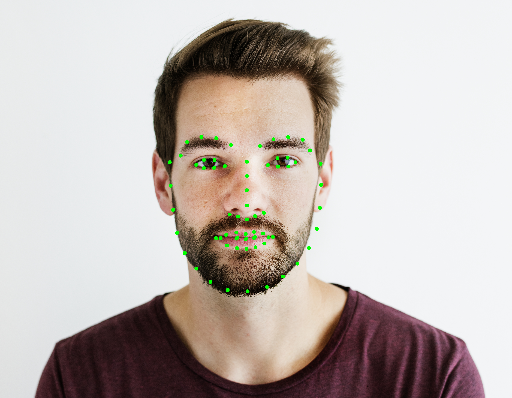

In [6]:
w, h = image.shape[:2]
scale = 512/h
vis_image = image.copy()
for k, v in landmarks.items():
    print("{} - Face landmarks.".format(k))
    for n in range(len(v)):
        x, y = v[n]
        cv2.circle(vis_image, (x, y), int(2/scale), (0, 255, 0), -1)
    vis_image = cv2.resize(vis_image, (0, 0), fx=scale, fy=scale)
    display(Image.fromarray(vis_image[..., ::-1]))

# recrop_images

In [7]:
from FaceBoxes import FaceBoxes
from TDDFA import TDDFA

# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

gpu_mode = 'gpu'
tddfa = TDDFA(gpu_mode=gpu_mode, **cfg)
face_boxes = FaceBoxes()

('examples/test/original/man.jpg', [array([1640, 1568]), array([1649, 1795]), array([1673, 2027]), array([1712, 2250]), array([1785, 2446]), array([1898, 2596]), array([2035, 2724]), array([2200, 2804]), array([2393, 2816]), array([2581, 2775]), array([2737, 2673]), array([2875, 2548]), array([2985, 2397]), array([3061, 2212]), array([3093, 2008]), array([3104, 1785]), array([3099, 1583]), array([1746, 1504]), array([1808, 1374]), array([1947, 1323]), array([2091, 1336]), array([2231, 1401]), array([2514, 1412]), array([2644, 1347]), array([2786, 1326]), array([2926, 1350]), array([2996, 1454]), array([2386, 1562]), array([2387, 1701]), array([2386, 1840]), array([2387, 1986]), array([2220, 2073]), array([2302, 2093]), array([2386, 2121]), array([2467, 2090]), array([2550, 2057]), array([1898, 1593]), array([1973, 1545]), array([2073, 1545]), array([2173, 1607]), array([2070, 1622]), array([1971, 1626]), array([2590, 1597]), array([2682, 1529]), array([2780, 1524]), array([2856, 1569])

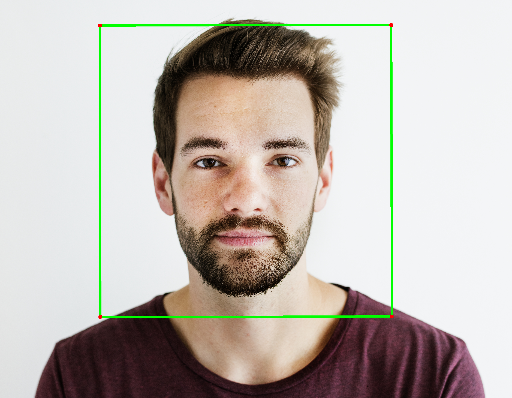

In [8]:
import copy
import tqdm

from recrop_images import get_crop_bound, crop_image, crop_final, find_center_bbox

# landmarks data
inputs = copy.deepcopy(landmarks)

size = 512
results_quad = {}
results_meta = {}
for i, item in enumerate(inputs.items()):

    # get initial cropping box(quad) using landmarks
    print(item)
    img_path, cur_landmarks = item
    img_path = img_path
    img_orig = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
    if img_orig is None:
        print(f'Cannot load image')
        continue
    quad, quad_c, quad_x, quad_y = get_crop_bound(cur_landmarks)

    # Visualize
    print(f'quad: {quad}')
    w, h = img_orig.shape[:2]
    scale = 512/h
    vis_image = img_orig.copy()
    vis_image = cv2.polylines(vis_image, [np.int32(quad).reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=int(2/scale))
    for n in range(len(quad)):
        x, y = np.int32(quad[n])
        cv2.circle(vis_image, (x, y), int(2/scale), (0, 0, 255), -1)
    vis_image = cv2.resize(vis_image, (0, 0), fx=scale, fy=scale)
    display(Image.fromarray(vis_image[..., ::-1]))


In [9]:
bound = np.array([[0, 0], [0, size-1], [size-1, size-1], [size-1, 0]], dtype=np.float32)
mat = cv2.getAffineTransform(quad[:3], bound[:3])
img = crop_image(img_orig, mat, size, size)
h, w = img.shape[:2]

In [10]:
# Detect faces, get 3DMM params and roi boxes
boxes = face_boxes(img)
assert len(boxes) > 0, f'No face detected!'
param_lst, roi_box_lst = tddfa(img, boxes)
box_idx = find_center_bbox(roi_box_lst, w, h)

In [11]:
from recrop_images import P2sRt, matrix2angle

param = param_lst[box_idx]
P = param[:12].reshape(3, -1)  # camera matrix
s_relative, R, t3d = P2sRt(P)
pose = matrix2angle(R)
pose = [p * 180 / np.pi for p in pose]

In [12]:
# Adjust z-translation in object space
R_ = param[:12].reshape(3, -1)[:, :3]
u = tddfa.bfm.u.reshape(3, -1, order='F')
trans_z = np.array([ 0, 0, 0.5*u[2].mean() ]) # Adjust the object center
trans = np.matmul(R_, trans_z.reshape(3,1))
t3d += trans.reshape(3)

In [13]:
''' Camera extrinsic estimation for GAN training '''
# Normalize P to fit in the original image (before 3DDFA cropping)
sx, sy, ex, ey = roi_box_lst[0]
scale_x = (ex - sx) / tddfa.size
scale_y = (ey - sy) / tddfa.size
t3d[0] = (t3d[0]-1) * scale_x + sx
t3d[1] = (tddfa.size-t3d[1]) * scale_y + sy
t3d[0] = (t3d[0] - 0.5*(w-1)) / (0.5*(w-1)) # Normalize to [-1,1]
t3d[1] = (t3d[1] - 0.5*(h-1)) / (0.5*(h-1)) # Normalize to [-1,1], y is flipped for image space
t3d[1] *= -1
t3d[2] = 0 # orthogonal camera is agnostic to Z (the model always outputs 66.67)

s_relative = s_relative * 2000
scale_x = (ex - sx) / (w-1)
scale_y = (ey - sy) / (h-1)
s = (scale_x + scale_y) / 2 * s_relative
# print(f"[{iteration}] s={s} t3d={t3d}")


In [14]:
assert not (s < 0.7 or s > 1.3), f"Skipping[{i+1-len(results_quad)}/{i+1}]: {img_path} s={s}"
assert not (abs(pose[0]) > 90 or abs(pose[1]) > 80 or abs(pose[2]) > 50), f"Skipping[{i+1-len(results_quad)}/{i+1}]: {img_path} pose={pose}"
assert not (abs(t3d[0]) > 1. or abs(t3d[1]) > 1.), f"Skipping[{i+1-len(results_quad)}/{i+1}]: {img_path} pose={pose} t3d={t3d}"

In [15]:
quad_c = quad_c + quad_x * t3d[0]
quad_c = quad_c - quad_y * t3d[1]
quad_x = quad_x * s
quad_y = quad_y * s
c, x, y = quad_c, quad_x, quad_y
quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y]).astype(np.float32)

In [16]:
from recrop_images import eg3dcamparams

s = 1
t3d = 0 * t3d
R[:,:3] = R[:,:3] * s
P = np.concatenate([R,t3d[:,None]],1)
P = np.concatenate([P, np.array([[0,0,0,1.]])],0)
results_meta[img_path] = eg3dcamparams(P.flatten())
results_quad[img_path] = quad

In [17]:
# Save cropped images
cropped_img = crop_final(img_orig, size=size, quad=quad)

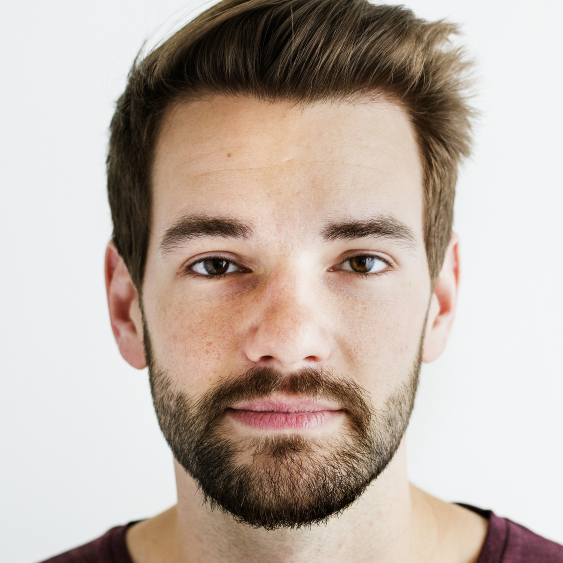

In [19]:
from PIL import Image

display(Image.fromarray(cropped_img[..., ::-1]))